# Using NCEI geoportal REST API to collect information about IOOS Regional Association archived data

by Mathew Biddle, Faculty Specialist, UMD/ESSIC/CICS at the NOAA National Centers for Environmental Information (NCEI)

### IOOS regional associations archive their non-federal observational data with NOAA's National Center for Environmental Information (NCEI). In this notebook we will use the [RESTful](https://github.com/Esri/geoportal-server/wiki/REST-API-Syntax) services of the [NCEI geoportal](https://www.nodc.noaa.gov/archivesearch/catalog/search/search.page) to collect metadata from the Archival Information Packages found in the NCEI archives. The metadata information are stored in [ISO 19115-2](https://wiki.earthdata.nasa.gov/display/NASAISO/ISO+19115-2) xml files which the NCEI geoportal uses for discovery of Archival Information Packages (AIPs). This example uses the ISO metadata records to display publication information as well as plot the time coverage of each AIP at NCEI which meets the search criteria.

First we import the owslib and numpy package. This allows us to parse the ISO xml records and process the information we gather.

Initialize a counter for plotting and a list to collect the NCEI Accession identifiers (we use this in the plotting routine). Also, update the namespaces dictionary from owslib to include the appropriate namespace reference for gmi and gml. 

For more information on ISO Namespaces see:  https://geo-ide.noaa.gov/wiki/index.php?title=ISO_Namespaces

In [1]:
from owslib.iso import namespaces

# Append gmi namespace to namespaces dictionary.
namespaces.update({"gmi": "http://www.isotc211.org/2005/gmi"})
namespaces.update({"gml": "http://www.opengis.net/gml/3.2"})
del namespaces[None]

### Now we select a Regional Association 
This is where the user identifies the Regional Association they are interested in. Simply uncomment the line that identifies the region of interest. The user can also omit the Regional Association to collect metadata information about all IOOS non-Federal observation data archived through the NCEI-IOOS pipeline.

In [2]:
# Select RA

RAs = {
    "AOOS": "Alaska Ocean Observing System",
    "CARICOOS": "Caribbean Coastal Ocean Observing System",
    "CeNCOOS": "Central and Northern California Coastal Ocean Observing System",
    "GCOOS": "Gulf of Mexico Coastal Ocean Observing System",
    "GLOS": "Great Lakes Observing System",
    "MARACOOS": "Mid-Atlantic Regional Association Coastal Ocean Observing System",
    "NANOOS": "Northwest Association of Networked Ocean Observing Systems",
    "NERACOOS": "Northeastern Regional Association of Coastal Ocean Observing Systems",
    "PacIOOS": "Pacific Islands Ocean Observing System",
    "SCCOOS": "Southern California Coastal Ocean Observing System",
    "SECOORA": "Southeast Coastal Ocean Observing Regional Association",
}

ra = RAs["SECOORA"]

### Next we generate a geoportal query and georss feed
To find more information about how to compile a geoportal query, have a look at [REST API Syntax](https://github.com/Esri/geoportal-server/wiki/REST-API-Syntax) and the [NCEI Search Tips](https://www.nodc.noaa.gov/search/granule/catalog/searchtips/searchtips.page) for the [NCEI geoportal](https://data.nodc.noaa.gov/geoportal/catalog/search/search.page). The example provided is specific to the NCEI-IOOS data pipeline project and only searches for non-federal timeseries data collected by each Regional Association. 

The query developed here can be updated to search for any Archival Information Packages at NCEI, therefore the user should develop the appropriate query using the [NCEI Geoportal](https://data.nodc.noaa.gov/geoportal/catalog/search/search.page) and update this portion of the code to identify the REST API of interest.

In [3]:
try:
    from urllib.parse import quote
except ImportError:
    from urllib import quote

# Generate geoportal query and georss feed.

# Base geoportal url.
baseurl = "https://www.ncei.noaa.gov/" "metadata/geoportal/opensearch" "?q=" #"dataThemeprojects_s:"

# Identify the project.
project = (
    '"Integrated Ocean Observing System Data Assembly Centers Data Stewardship Program"'
#    ' OR "HFRadarRadial"'
#    ' OR "HFRadarRTVector"'
)

# Identify the Regional Association
ra = ' AND "{}" '.format(ra)

# Identify the platform.
platform = 'AND "FIXED PLATFORM"'

# Identify the amount of records and format of the response: 1 to 1010 records.
records = "&start=1&num=1010"

# Identify the format of the response: georss.
response_format = "&f=csv"

# Combine the URL.
url = "{}{}".format(baseurl, quote( '(' + project + ra + platform + ')' ) + records + response_format)

print("Identified response format:\n{}".format(url))
print(
    "\nSearch page response:\n{}".format(url.replace(response_format, "&f=searchPage"))
)

Identified response format:
https://www.ncei.noaa.gov/metadata/geoportal/opensearch?q=%28%22Integrated%20Ocean%20Observing%20System%20Data%20Assembly%20Centers%20Data%20Stewardship%20Program%22%20AND%20%22Southeast%20Coastal%20Ocean%20Observing%20Regional%20Association%22%20AND%20%22FIXED%20PLATFORM%22%29&start=1&num=1010&f=csv

Search page response:
https://www.ncei.noaa.gov/metadata/geoportal/opensearch?q=%28%22Integrated%20Ocean%20Observing%20System%20Data%20Assembly%20Centers%20Data%20Stewardship%20Program%22%20AND%20%22Southeast%20Coastal%20Ocean%20Observing%20Regional%20Association%22%20AND%20%22FIXED%20PLATFORM%22%29&start=1&num=1010&f=searchPage


### Time to query the portal and parse out the csv response
Here we are opening the specified REST API and parsing it into a string. Then, since we identified it as a csv format above, we parse it using the Pandas package. We also split the Data_Date_Range column into two columns, `data_start_date` and `data_end_date` to have that useful information available.

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv(url)

df[['data_start_date','data_end_date']] = df['Data_Date_Range'].str.split(' to ',expand=True)
df['data_start_date'] = pd.to_datetime(df['data_start_date'])
df['data_end_date'] = pd.to_datetime(df['data_end_date']) + pd.Timedelta(np.timedelta64(1, "ms"))

df

,Id,Title,Description,West,South,East,North,Link_Xml,Link_1,Link_2,Link_3,Link_4,Data_Date_Range,Date_Published,data_start_date,data_end_date
0,gov.noaa.nodc:0118764,Oceanographic and surface meteorological data ...,NaN,-80.65300,25.22300,-80.65300,25.22300,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2014-02-13T00:00:00Z to 2016-05-31T23:59:59.999Z,2014-05-29T00:00:00Z,2014-02-13 00:00:00+00:00,2016-06-01 00:00:00+00:00
1,gov.noaa.nodc:0118765,Oceanographic and surface meteorological data ...,NaN,-81.04400,25.61900,-81.04400,25.61900,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2014-02-13T00:00:00Z to 2016-05-31T23:59:59.999Z,2014-05-29T00:00:00Z,2014-02-13 00:00:00+00:00,2016-06-01 00:00:00+00:00
2,gov.noaa.nodc:0118751,Oceanographic and surface meteorological data ...,NaN,-81.02900,25.37600,-81.02900,25.37600,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2014-02-13T00:00:00Z to 2016-05-31T23:59:59.999Z,2014-05-29T00:00:00Z,2014-02-13 00:00:00+00:00,2016-06-01 00:00:00+00:00
3,gov.noaa.nodc:0118752,Oceanographic and surface meteorological data ...,NaN,-80.79700,25.17000,-80.79700,25.17000,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2014-02-13T00:00:00Z to 2016-05-31T23:59:59.999Z,2014-05-29T00:00:00Z,2014-02-13 00:00:00+00:00,2016-06-01 00:00:00+00:00
4,gov.noaa.nodc:0118753,Oceanographic and surface meteorological data ...,NaN,-80.44400,25.25400,-80.44400,25.25400,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2014-02-13T00:00:00Z to 2016-05-31T23:59:59.999Z,2014-05-29T00:00:00Z,2014-02-13 00:00:00+00:00,2016-06-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,gov.noaa.nodc:0171346,"Chemical, meteorological and other data collec...",NaN,-85.05807,29.67431,-85.05807,29.67431,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2015-12-01T00:00:00Z to 2018-10-10T23:59:59.999Z,2018-03-16T00:00:00Z,2015-12-01 00:00:00+00:00,2018-10-11 00:00:00+00:00
88,gov.noaa.nodc:0171345,"Chemical, meteorological and other data collec...",NaN,-85.02770,29.60139,-85.02770,29.60139,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2015-11-09T00:00:00Z to 2020-03-09T23:59:59.999Z,2018-03-16T00:00:00Z,2015-11-09 00:00:00+00:00,2020-03-10 00:00:00+00:00
89,gov.noaa.nodc:0171332,"Biological, chemical and other data collected ...",NaN,-80.20233,27.22439,-80.20233,27.22439,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2015-10-07T00:00:00Z to 2020-06-18T23:59:59.999Z,2018-03-16T00:00:00Z,2015-10-07 00:00:00+00:00,2020-06-19 00:00:00+00:00
90,gov.noaa.nodc:0163764,"Biological, chemical and other data collected ...",NaN,-80.34311,27.53483,-80.34311,27.53483,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2015-10-07T00:00:00Z to 2020-06-01T23:59:59.999Z,2017-06-28T00:00:00Z,2015-10-07 00:00:00+00:00,2020-06-02 00:00:00+00:00


Now, lets pull out all the ISO metadata record links and print them out so the user can browse to the metadata record and look for what items they might be interested in.

In [5]:
# parse the csv response

print("Found %i records" % len(df))
for item in df['Link_Xml']:
    print(item)  # URL to ISO19115-2 record.

Found 92 records
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118764/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118765/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118751/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118752/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118753/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118746/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118747/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118748/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118755/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0118758/xml
http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.n

### Lets collect what we have found
Now that we have all the ISO metadata records we are interested in, it's time to do something fun with them. In this example we want to generate a timeseries plot of the data coverage for the "Southern California Coastal Ocean Observing System" stations we have archived at NCEI.

First we need to collect some information. We loop through each iso record to collect metadata information about each package. The example here shows how to collect the following items:
   1. NCEI Archival Information Package (AIP) Accession ID (7-digit Accession Number) 
   2. The first date the archive package was published.
   3. The platform code identified from the provider.
   4. The version number and date it was published.
   5. The current AIP size, in MB.

There are plenty of other metadata elements to collect from the ISO records, so we recommend browsing to one of the records and having a look at the items of interest to your community.

In [6]:
# Process each iso record.
%matplotlib inline

from datetime import datetime
import xml.etree.ElementTree as ET
from owslib import util
from urllib.request import urlopen


df[['provider_platform_name','NCEI_accession_number','package_size_mb']] = ''

# For each accession in response.
for url in df['Link_Xml']:

    iso = urlopen(url)
    iso_tree = ET.parse(iso)
    root = iso_tree.getroot()

    # Collect Publication date information.
    date_path = (
        ".//"
        "gmd:identificationInfo/"
        "gmd:MD_DataIdentification/"
        "gmd:citation/"
        "gmd:CI_Citation/"
        "gmd:date/"
        "gmd:CI_Date/"
        "gmd:date/gco:Date"
    )
    # First published date.
    pubdate = root.find(date_path, namespaces)
    print("\nFirst published date = %s" % util.testXMLValue(pubdate))

    # Collect keyword terms of interest.
    for MD_keywords in root.iterfind('.//gmd:descriptiveKeywords/gmd:MD_Keywords', namespaces):

        for thesaurus_name in MD_keywords.iterfind('.//gmd:thesaurusName/gmd:CI_Citation/gmd:title/gco:CharacterString', namespaces):
            
            if thesaurus_name.text == "Provider Platform Names":

                plat_name = MD_keywords.find('.//gmd:keyword/gco:CharacterString', namespaces).text
                print("Provider Platform Code = %s" % plat_name)
                df.loc[df.Link_Xml == url, ['provider_platform_name']] = plat_name
                break
                
            elif thesaurus_name.text == "NCEI ACCESSION NUMBER":
                acce_no = MD_keywords.find('.//gmd:keyword/gmx:Anchor', namespaces).text
                print("Accession:",acce_no)
                df.loc[df.Link_Xml == url, ['NCEI_accession_number']] = acce_no
                break
            
    # Pull out the version information.
    # Iterate through each processing step which is an NCEI version.
    for process_step in root.iterfind(".//gmd:processStep", namespaces):
        # Only parse gco:DateTime and gmd:title/gco:CharacterString.
        vers_title = (
            ".//"
            "gmi:LE_ProcessStep/"
            "gmi:output/"
            "gmi:LE_Source/"
            "gmd:sourceCitation/"
            "gmd:CI_Citation/"
            "gmd:title/"
            "gco:CharacterString"
        )
        vers_date = (
            ".//" 
            "gmi:LE_ProcessStep/" 
            "gmd:dateTime/"
            "gco:DateTime"
        )
        if process_step.findall(vers_date, namespaces) and process_step.findall(vers_title, namespaces):
            # Extract dateTime for each version.
            datetimes = process_step.findall(vers_date, namespaces)
            # Extract title string (contains version number).
            titles = process_step.findall(vers_title, namespaces)
            print(
                "{} = {}".format(
                    util.testXMLValue(titles[0]), util.testXMLValue(datetimes[0])
                )
            )
            df.loc[df.Link_Xml == url, ['version_info']] = "{} = {}".format(
                    util.testXMLValue(titles[0]), util.testXMLValue(datetimes[0]))

    # Collect package size information.
    # Iterate through transfer size nodes.
    for trans_size in root.iterfind(".//gmd:transferSize", namespaces):

        if trans_size.find(".//gco:Real", namespaces).text:
            
            sizes = trans_size.find(".//gco:Real", namespaces).text
            print("Current AIP Size = %s MB" % sizes)
                
            df.loc[df.Link_Xml == url, ['package_size_mb']] = float(sizes)
            break

        break


First published date = 2014-05-29
Accession: 0118764
NCEI Accession 0118764 v1.1 = 2014-05-29T18:32:11Z
NCEI Accession 0118764 v2.2 = 2014-06-06T12:32:12Z
NCEI Accession 0118764 v3.3 = 2014-07-17T11:20:09Z
NCEI Accession 0118764 v4.4 = 2014-08-07T07:32:06Z
NCEI Accession 0118764 v5.5 = 2014-09-04T11:27:15Z
NCEI Accession 0118764 v6.6 = 2014-10-05T07:32:07Z
NCEI Accession 0118764 v7.7 = 2014-11-05T07:32:11Z
NCEI Accession 0118764 v8.8 = 2014-12-08T02:52:33Z
NCEI Accession 0118764 v9.9 = 2015-01-05T07:32:27Z
NCEI Accession 0118764 v10.10 = 2015-02-05T07:32:26Z
NCEI Accession 0118764 v11.11 = 2015-03-05T07:32:18Z
NCEI Accession 0118764 v12.12 = 2015-04-10T07:32:25Z
NCEI Accession 0118764 v13.13 = 2015-05-05T07:32:38Z
NCEI Accession 0118764 v14.14 = 2015-06-05T07:32:31Z
NCEI Accession 0118764 v15.15 = 2015-07-05T07:32:33Z
NCEI Accession 0118764 v16.16 = 2015-08-13T09:02:15Z
NCEI Accession 0118764 v17.17 = 2015-09-05T07:32:33Z
NCEI Accession 0118764 v18.18 = 2015-10-15T07:32:43Z
NCEI Acces


First published date = 2014-05-29
Accession: 0118747
NCEI Accession 0118747 v1.1 = 2014-05-29T18:30:05Z
NCEI Accession 0118747 v2.2 = 2014-06-06T12:28:09Z
NCEI Accession 0118747 v3.3 = 2014-07-17T05:13:46Z
NCEI Accession 0118747 v4.4 = 2014-08-04T09:34:48Z
NCEI Accession 0118747 v5.5 = 2014-09-04T11:22:16Z
NCEI Accession 0118747 v6.6 = 2014-10-04T07:32:18Z
NCEI Accession 0118747 v7.7 = 2014-11-04T07:32:23Z
NCEI Accession 0118747 v8.8 = 2014-12-05T13:57:55Z
NCEI Accession 0118747 v9.9 = 2015-01-04T07:33:08Z
NCEI Accession 0118747 v10.10 = 2015-02-04T07:33:08Z
NCEI Accession 0118747 v11.11 = 2015-03-04T07:32:36Z
NCEI Accession 0118747 v12.12 = 2015-04-09T07:33:25Z
NCEI Accession 0118747 v13.13 = 2015-05-04T07:33:22Z
NCEI Accession 0118747 v14.14 = 2015-06-04T07:33:17Z
NCEI Accession 0118747 v15.15 = 2015-07-04T07:33:15Z
NCEI Accession 0118747 v16.16 = 2015-08-12T22:01:27Z
NCEI Accession 0118747 v17.17 = 2015-09-04T07:33:42Z
NCEI Accession 0118747 v18.18 = 2015-10-14T07:33:21Z
NCEI Acces


First published date = 2014-05-29
Accession: 0118760
NCEI Accession 0118760 v1.1 = 2014-05-29T18:31:18Z
NCEI Accession 0118760 v2.2 = 2014-06-06T12:29:23Z
NCEI Accession 0118760 v3.3 = 2014-07-17T11:19:17Z
NCEI Accession 0118760 v4.4 = 2014-08-07T07:31:28Z
NCEI Accession 0118760 v5.5 = 2014-09-04T11:26:13Z
NCEI Accession 0118760 v6.6 = 2014-10-05T07:31:16Z
NCEI Accession 0118760 v7.7 = 2014-11-05T07:31:17Z
NCEI Accession 0118760 v8.8 = 2014-12-08T02:52:16Z
NCEI Accession 0118760 v9.9 = 2015-01-05T07:32:08Z
NCEI Accession 0118760 v10.10 = 2015-02-05T07:32:08Z
NCEI Accession 0118760 v11.11 = 2015-03-05T07:31:22Z
NCEI Accession 0118760 v12.12 = 2015-04-10T07:31:32Z
NCEI Accession 0118760 v13.13 = 2015-05-05T07:32:11Z
NCEI Accession 0118760 v14.14 = 2015-06-05T07:32:08Z
NCEI Accession 0118760 v15.15 = 2015-07-05T07:32:08Z
NCEI Accession 0118760 v16.16 = 2015-08-13T09:01:46Z
NCEI Accession 0118760 v17.17 = 2015-09-05T07:31:28Z
NCEI Accession 0118760 v18.18 = 2015-10-15T07:31:32Z
NCEI Acces


First published date = 2014-05-29
Accession: 0118767
NCEI Accession 0118767 v1.1 = 2014-05-29T18:32:18Z
NCEI Accession 0118767 v2.2 = 2014-06-06T12:32:21Z
NCEI Accession 0118767 v3.3 = 2014-07-17T11:20:19Z
NCEI Accession 0118767 v4.4 = 2014-08-07T07:32:16Z
NCEI Accession 0118767 v5.5 = 2014-09-04T11:27:25Z
NCEI Accession 0118767 v6.6 = 2014-10-05T07:32:18Z
NCEI Accession 0118767 v7.7 = 2014-11-05T07:32:24Z
NCEI Accession 0118767 v8.8 = 2014-12-08T02:53:15Z
NCEI Accession 0118767 v9.9 = 2015-01-05T07:33:47Z
NCEI Accession 0118767 v10.10 = 2015-02-05T07:33:09Z
NCEI Accession 0118767 v11.11 = 2015-03-05T07:32:34Z
NCEI Accession 0118767 v12.12 = 2015-04-10T07:33:21Z
NCEI Accession 0118767 v13.13 = 2015-05-05T07:33:15Z
NCEI Accession 0118767 v14.14 = 2015-06-05T07:33:16Z
NCEI Accession 0118767 v15.15 = 2015-07-05T07:33:20Z
NCEI Accession 0118767 v16.16 = 2015-08-13T09:02:37Z
NCEI Accession 0118767 v17.17 = 2015-09-05T07:33:26Z
NCEI Accession 0118767 v18.18 = 2015-10-15T07:33:30Z
NCEI Acces


First published date = 2014-05-29
Accession: 0118769
NCEI Accession 0118769 v1.1 = 2014-05-29T18:33:05Z
NCEI Accession 0118769 v2.2 = 2014-06-06T12:32:27Z
NCEI Accession 0118769 v3.3 = 2014-07-17T11:20:26Z
NCEI Accession 0118769 v4.4 = 2014-08-07T07:32:24Z
NCEI Accession 0118769 v5.5 = 2014-09-04T11:27:31Z
NCEI Accession 0118769 v6.6 = 2014-10-05T07:32:26Z
NCEI Accession 0118769 v7.7 = 2014-11-05T07:32:32Z
NCEI Accession 0118769 v8.8 = 2014-12-08T02:53:24Z
NCEI Accession 0118769 v9.9 = 2015-01-05T07:33:52Z
NCEI Accession 0118769 v10.10 = 2015-02-05T07:33:15Z
NCEI Accession 0118769 v11.11 = 2015-03-05T07:33:08Z
NCEI Accession 0118769 v12.12 = 2015-04-10T07:33:33Z
NCEI Accession 0118769 v13.13 = 2015-05-05T07:33:22Z
NCEI Accession 0118769 v14.14 = 2015-06-05T07:33:22Z
NCEI Accession 0118769 v15.15 = 2015-07-05T07:33:26Z
NCEI Accession 0118769 v16.16 = 2015-08-13T09:02:44Z
Current AIP Size = 1.572 MB

First published date = 2014-05-29
Accession: 0118790
NCEI Accession 0118790 v1.1 = 2014


First published date = 2014-05-29
Accession: 0118787
NCEI Accession 0118787 v1.1 = 2014-05-29T18:36:06Z
NCEI Accession 0118787 v2.2 = 2015-01-06T07:32:36Z
NCEI Accession 0118787 v3.3 = 2015-02-06T07:33:13Z
NCEI Accession 0118787 v4.4 = 2015-03-06T07:33:21Z
NCEI Accession 0118787 v5.5 = 2015-04-11T07:33:35Z
NCEI Accession 0118787 v6.6 = 2015-05-06T07:33:24Z
NCEI Accession 0118787 v7.7 = 2015-06-06T07:32:31Z
NCEI Accession 0118787 v8.8 = 2015-07-06T07:33:14Z
NCEI Accession 0118787 v9.9 = 2015-08-16T07:33:21Z
NCEI Accession 0118787 v10.10 = 2015-09-06T07:31:18Z
NCEI Accession 0118787 v11.11 = 2015-10-16T07:49:31Z
NCEI Accession 0118787 v12.12 = 2015-11-06T07:31:29Z
NCEI Accession 0118787 v13.13 = 2015-12-06T07:33:11Z
NCEI Accession 0118787 v14.14 = 2016-01-06T07:32:12Z
NCEI Accession 0118787 v15.15 = 2016-02-06T08:26:45Z
NCEI Accession 0118787 v16.16 = 2016-03-06T07:31:18Z
NCEI Accession 0118787 v17.17 = 2016-04-06T07:41:33Z
NCEI Accession 0118787 v18.18 = 2016-05-06T07:33:16Z
NCEI Acces


First published date = 2014-05-29
Accession: 0118770
NCEI Accession 0118770 v1.1 = 2014-05-29T18:33:07Z
NCEI Accession 0118770 v2.2 = 2014-06-06T12:33:06Z
NCEI Accession 0118770 v3.3 = 2014-07-17T11:21:07Z
NCEI Accession 0118770 v4.4 = 2014-08-07T07:33:06Z
NCEI Accession 0118770 v5.5 = 2014-09-04T11:28:10Z
NCEI Accession 0118770 v6.6 = 2014-10-05T07:33:08Z
NCEI Accession 0118770 v7.7 = 2014-11-05T07:33:12Z
NCEI Accession 0118770 v8.8 = 2014-12-08T02:53:33Z
NCEI Accession 0118770 v9.9 = 2015-01-05T07:34:02Z
NCEI Accession 0118770 v10.10 = 2015-02-05T07:33:26Z
NCEI Accession 0118770 v11.11 = 2015-03-05T07:33:20Z
NCEI Accession 0118770 v12.12 = 2015-04-10T07:33:49Z
NCEI Accession 0118770 v13.13 = 2015-05-05T07:34:10Z
NCEI Accession 0118770 v14.14 = 2015-06-05T07:33:36Z
NCEI Accession 0118770 v15.15 = 2015-07-05T07:34:17Z
NCEI Accession 0118770 v16.16 = 2015-08-13T09:03:02Z
NCEI Accession 0118770 v17.17 = 2015-09-05T07:34:21Z
NCEI Accession 0118770 v18.18 = 2015-10-15T07:34:14Z
NCEI Acces


First published date = 2014-05-29
Accession: 0118741
NCEI Accession 0118741 v1.1 = 2014-05-29T18:29:05Z
NCEI Accession 0118741 v2.2 = 2014-06-06T00:32:11Z
NCEI Accession 0118741 v3.3 = 2014-07-17T05:13:16Z
NCEI Accession 0118741 v4.4 = 2014-08-04T09:34:20Z
NCEI Accession 0118741 v5.5 = 2014-09-04T11:21:12Z
NCEI Accession 0118741 v6.6 = 2014-10-04T07:31:11Z
NCEI Accession 0118741 v7.7 = 2014-11-04T07:31:13Z
NCEI Accession 0118741 v8.8 = 2014-12-05T13:57:20Z
NCEI Accession 0118741 v9.9 = 2015-01-04T07:31:14Z
NCEI Accession 0118741 v10.10 = 2015-02-04T07:31:19Z
NCEI Accession 0118741 v11.11 = 2015-03-04T07:31:20Z
NCEI Accession 0118741 v12.12 = 2015-04-09T07:31:25Z
NCEI Accession 0118741 v13.13 = 2015-05-04T07:32:09Z
NCEI Accession 0118741 v14.14 = 2015-06-04T07:31:21Z
NCEI Accession 0118741 v15.15 = 2015-07-04T07:31:24Z
NCEI Accession 0118741 v16.16 = 2015-08-12T21:59:10Z
NCEI Accession 0118741 v17.17 = 2015-09-04T07:31:31Z
NCEI Accession 0118741 v18.18 = 2015-10-14T07:31:31Z
NCEI Acces


First published date = 2014-05-29
Accession: 0118772
NCEI Accession 0118772 v1.1 = 2014-05-29T18:33:13Z
NCEI Accession 0118772 v2.2 = 2014-06-06T12:33:10Z
NCEI Accession 0118772 v3.3 = 2014-07-17T11:21:13Z
NCEI Accession 0118772 v4.4 = 2014-08-07T07:33:12Z
NCEI Accession 0118772 v5.5 = 2014-09-04T11:28:16Z
NCEI Accession 0118772 v6.6 = 2014-10-05T07:33:15Z
NCEI Accession 0118772 v7.7 = 2014-11-05T07:33:20Z
NCEI Accession 0118772 v8.8 = 2014-12-08T02:54:08Z
NCEI Accession 0118772 v9.9 = 2015-01-05T07:35:09Z
NCEI Accession 0118772 v10.10 = 2015-02-05T07:33:31Z
NCEI Accession 0118772 v11.11 = 2015-03-05T07:33:29Z
NCEI Accession 0118772 v12.12 = 2015-04-10T07:34:16Z
NCEI Accession 0118772 v13.13 = 2015-05-05T07:34:16Z
NCEI Accession 0118772 v14.14 = 2015-07-05T07:34:23Z
NCEI Accession 0118772 v15.15 = 2015-08-13T09:03:15Z
NCEI Accession 0118772 v16.16 = 2015-12-05T09:20:15Z
NCEI Accession 0118772 v17.17 = 2016-04-05T07:34:44Z
NCEI Accession 0118772 v18.18 = 2016-05-05T07:34:28Z
Current AI


First published date = 2018-03-16
Accession: 0171330
Provider Platform Code = Indian River Lagoon - Sebastian (IRL-SB)
NCEI Accession 0171330 v1.1 = 2018-03-16T07:20:10Z
NCEI Accession 0171330 v2.2 = 2018-04-23T07:26:20Z
NCEI Accession 0171330 v3.3 = 2018-05-17T07:20:23Z
NCEI Accession 0171330 v4.4 = 2018-06-18T07:16:20Z
NCEI Accession 0171330 v5.5 = 2018-07-17T07:21:24Z
NCEI Accession 0171330 v6.6 = 2018-08-17T08:10:33Z
NCEI Accession 0171330 v7.7 = 2018-10-16T07:20:20Z
NCEI Accession 0171330 v8.8 = 2018-11-18T11:26:30Z
NCEI Accession 0171330 v9.9 = 2018-12-18T13:58:55Z
NCEI Accession 0171330 v10.10 = 2019-01-18T07:33:11Z
NCEI Accession 0171330 v11.11 = 2019-03-21T10:42:06Z
NCEI Accession 0171330 v12.12 = 2019-07-22T19:09:40Z
NCEI Accession 0171330 v13.13 = 2019-08-18T09:46:29Z
NCEI Accession 0171330 v14.14 = 2019-09-18T09:42:10Z
NCEI Accession 0171330 v15.15 = 2019-10-18T14:26:29Z
NCEI Accession 0171330 v16.16 = 2019-11-18T10:57:49Z
NCEI Accession 0171330 v17.17 = 2019-12-18T07:16:2


First published date = 2018-03-16
Accession: 0171328
Provider Platform Code = Indian River Lagoon - Fort Pierce (IRL-FP)
NCEI Accession 0171328 v1.1 = 2018-03-16T07:19:20Z
NCEI Accession 0171328 v2.2 = 2018-04-23T07:26:12Z
NCEI Accession 0171328 v3.3 = 2018-05-17T07:20:13Z
NCEI Accession 0171328 v4.4 = 2018-06-18T07:16:08Z
NCEI Accession 0171328 v5.5 = 2018-07-17T07:21:10Z
NCEI Accession 0171328 v6.6 = 2018-08-17T08:10:19Z
NCEI Accession 0171328 v7.7 = 2018-10-16T07:20:08Z
NCEI Accession 0171328 v8.8 = 2018-11-17T07:48:29Z
NCEI Accession 0171328 v9.9 = 2018-12-17T12:58:35Z
NCEI Accession 0171328 v10.10 = 2019-01-17T07:49:05Z
NCEI Accession 0171328 v11.11 = 2019-03-21T10:41:43Z
NCEI Accession 0171328 v12.12 = 2019-07-22T19:09:10Z
NCEI Accession 0171328 v13.13 = 2019-08-17T08:11:31Z
NCEI Accession 0171328 v14.14 = 2019-09-17T09:28:35Z
NCEI Accession 0171328 v15.15 = 2019-10-17T13:06:06Z
NCEI Accession 0171328 v16.16 = 2019-11-18T10:57:14Z
NCEI Accession 0171328 v17.17 = 2019-12-17T14:51


First published date = 2018-03-16
Accession: 0171325
Provider Platform Code = 2nd Avenue Pier
NCEI Accession 0171325 v1.1 = 2018-03-16T07:19:07Z
NCEI Accession 0171325 v2.2 = 2018-04-19T07:46:48Z
NCEI Accession 0171325 v3.3 = 2018-05-17T07:19:48Z
NCEI Accession 0171325 v4.4 = 2018-06-17T07:20:14Z
NCEI Accession 0171325 v5.5 = 2018-07-17T07:19:27Z
NCEI Accession 0171325 v6.6 = 2018-08-17T08:09:44Z
NCEI Accession 0171325 v7.7 = 2018-10-16T07:18:27Z
NCEI Accession 0171325 v8.8 = 2018-11-17T07:47:36Z
NCEI Accession 0171325 v9.9 = 2018-12-17T12:57:30Z
NCEI Accession 0171325 v10.10 = 2019-01-17T07:48:10Z
NCEI Accession 0171325 v11.11 = 2019-02-17T09:52:41Z
NCEI Accession 0171325 v12.12 = 2019-03-17T11:25:54Z
NCEI Accession 0171325 v13.13 = 2019-07-21T07:19:55Z
NCEI Accession 0171325 v14.14 = 2019-08-17T08:10:07Z
NCEI Accession 0171325 v15.15 = 2019-09-17T09:18:57Z
NCEI Accession 0171325 v16.16 = 2019-10-17T13:04:59Z
NCEI Accession 0171325 v17.17 = 2019-11-17T10:45:07Z
NCEI Accession 0171325


First published date = 2018-03-16
Accession: 0171345
Provider Platform Code = Pilot's Cove, Apalachicola Bay,
NCEI Accession 0171345 v1.1 = 2018-03-16T07:23:07Z
NCEI Accession 0171345 v2.2 = 2018-04-19T07:47:44Z
NCEI Accession 0171345 v3.3 = 2018-08-18T07:19:09Z
NCEI Accession 0171345 v4.4 = 2018-10-16T07:24:14Z
NCEI Accession 0171345 v5.5 = 2018-11-18T11:28:55Z
NCEI Accession 0171345 v6.6 = 2018-12-18T14:03:03Z
NCEI Accession 0171345 v7.7 = 2019-01-17T07:51:02Z
NCEI Accession 0171345 v8.8 = 2019-02-17T09:54:56Z
NCEI Accession 0171345 v9.9 = 2019-03-21T02:36:30Z
NCEI Accession 0171345 v10.10 = 2019-07-19T07:22:26Z
NCEI Accession 0171345 v11.11 = 2019-08-18T09:49:20Z
NCEI Accession 0171345 v12.12 = 2019-09-18T09:44:29Z
NCEI Accession 0171345 v13.13 = 2019-10-18T14:52:50Z
NCEI Accession 0171345 v14.14 = 2019-11-18T11:08:14Z
NCEI Accession 0171345 v15.15 = 2019-12-18T07:21:08Z
NCEI Accession 0171345 v16.16 = 2020-01-09T14:37:28Z
NCEI Accession 0171345 v17.17 = 2020-03-19T07:48:49Z
NCEI A

### Create a timeseries plot of data coverage
Now that we have a DataFrame with all the information we're interested in, lets make a time coverage plot for all the AIP's at NCEI.

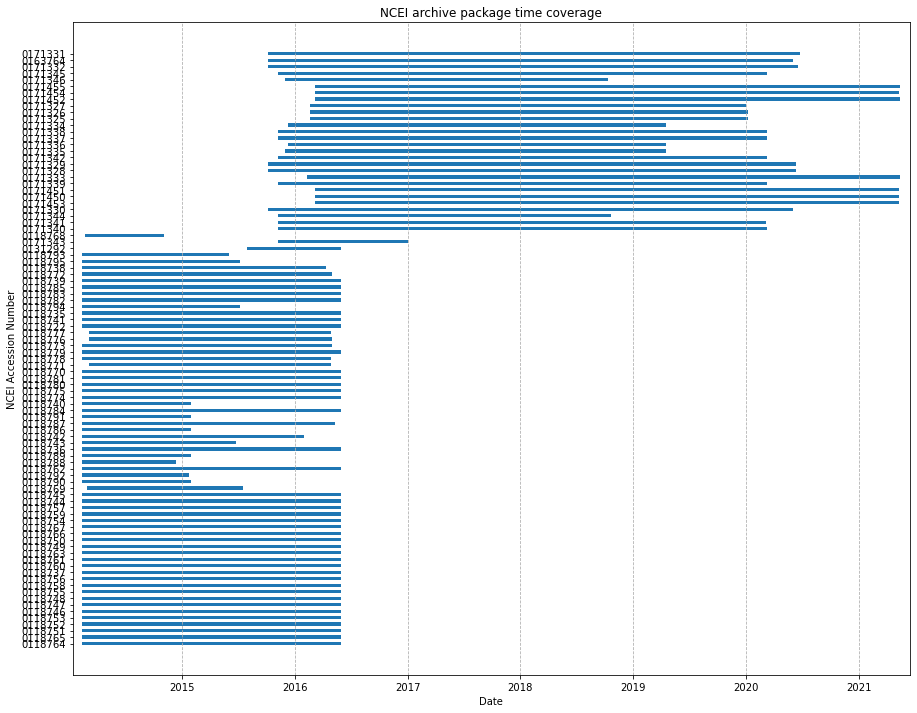

In [7]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
    
ypos = range(len(df))
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the data
ax.barh(ypos, mdates.date2num(df['data_end_date']) - mdates.date2num(df['data_start_date']), 
        left = mdates.date2num(df['data_start_date']), 
        height = 0.5, 
        align = 'center')

xlim = ( mdates.date2num(df['data_start_date'].min() - pd.Timedelta(np.timedelta64(1, "M"))),
         mdates.date2num(df['data_end_date'].max() + pd.Timedelta(np.timedelta64(1, "M"))) )

ax.set_xlim(xlim)
ax.set(yticks = np.arange(0, len(df)))
ax.tick_params(which="both", direction="out")
ax.set_ylabel("NCEI Accession Number")
ax.set_yticklabels(df['NCEI_accession_number'])
ax.set_title('NCEI archive package time coverage')

ax.xaxis_date()
ax.set_xlabel('Date')

plt.grid(axis='x', linestyle='--')

plt.show()

This procedure has been developed as an example of how to use NCEI's geoportal REST API's to collect information about packages that have been archived at NCEI. The intention is to provide some guidance and ways to collect this information without having to request it directly from NCEI. There are a significant amount of metadata elements which NCEI makes available through their ISO metadata records. Therefore, anyone interested in collecting other information from the records at NCEI should have a look at the ISO metadata records and determine which items are of interest to their community. Then, update the example code provided to collect that information.